In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score
import cv2
from imblearn.over_sampling import RandomOverSampler, SMOTE

# DADOS

In [2]:
xt = np.load("Dados/Xtrain_Classification1.npy") 
yt = np.load("Dados/ytrain_Classification1.npy")
xScaled =  (xt).astype('float32')/255.0

In [3]:
X_train, X_test, y_train, y_test = train_test_split(xScaled, yt, test_size=0.2, shuffle=True, random_state=10, stratify=yt)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=10,stratify=y_train)

# sm = SMOTE(random_state = 2) 
# X_train, y_train = sm.fit_resample(X_train, y_train) 

# Rodar imagens

In [4]:
X_testrs = X_test.reshape(-1, 28,28,3)
X_trainrs = X_train.reshape(-1, 28,28,3)
X_validationrs = X_validation.reshape(-1, 28,28,3)
addx = np.array([])
addy = np.array([]) 
for idx, i in enumerate(y_train):
        for l in range(3):
            if l == 0:
                if not np.any(addx):
                    addx = np.expand_dims(cv2.rotate(X_trainrs[idx], cv2.ROTATE_90_COUNTERCLOCKWISE), axis=0)
                    addy = np.append(addy,i)
                else:
                    aux = np.expand_dims(cv2.rotate(X_trainrs[idx], cv2.ROTATE_90_COUNTERCLOCKWISE), axis=0)
                    addx = np.append(addx,aux,axis=0)
                    addy = np.append(addy,i)
                   
            elif l == 1:
                aux = np.expand_dims(cv2.rotate(X_trainrs[idx], cv2.ROTATE_90_CLOCKWISE), axis=0) 
                addx = np.append(addx,aux,axis=0)
                addy = np.append(addy,i)
            
            elif l == 2:
                aux = np.expand_dims(cv2.rotate(X_trainrs[idx],  cv2.ROTATE_180), axis=0) 
                addx = np.append(addx,aux,axis=0)
                addy = np.append(addy,i)

X_trainrs = np.append(X_trainrs,addx,axis=0) 
y_train = np.append(y_train,addy)




In [5]:

X_trainrs = X_trainrs.reshape(-1, 28*28*3)  
oversample = RandomOverSampler(sampling_strategy='minority')
X_trainrs, y_train = oversample.fit_resample(X_trainrs, y_train)
X_trainrs = X_trainrs.reshape(-1, 28,28,3)
y_train = to_categorical(y_train,2)
y_validation = to_categorical(y_validation,2)
y_test = to_categorical(y_test,2)


# Apenas para ver as imagens

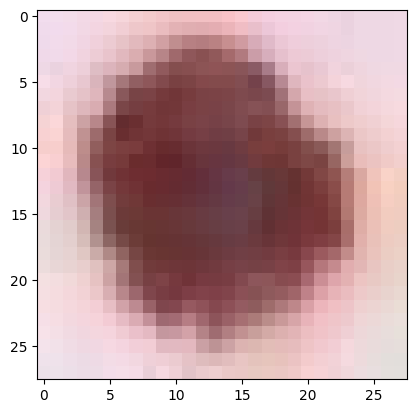

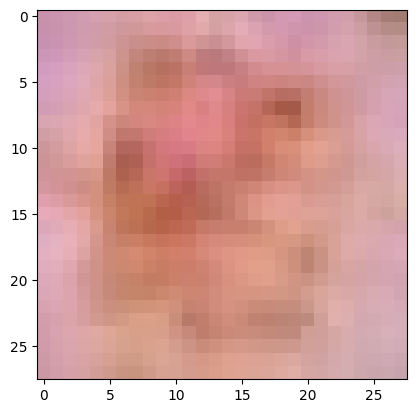

[[0. 1.]
 [0. 1.]]


In [6]:
img = X_trainrs
for i in img[-2:]:
    plt.imshow(i)
    plt.show()
print(y_train[-2:])

# CNN

In [33]:
MLP = Sequential()
MLP.add(Convolution2D(16, kernel_size = 3, activation='relu', input_shape=(28, 28, 3), padding='same'))
MLP.add(MaxPooling2D((2, 2), strides=2))
MLP.add(Convolution2D(32, kernel_size = 3, activation='relu', padding='same'))
MLP.add(MaxPooling2D((2, 2), strides=2))
MLP.add(Convolution2D(32, kernel_size = 7, activation='relu', padding='same'))
MLP.add(MaxPooling2D((2, 2), strides=2))
MLP.add(Flatten())
MLP.add(Dense(64, activation='relu'))
MLP.add(Dense(32, activation='relu'))
MLP.add(Dropout(0.5))
MLP.add(Dense(2, activation='softmax'))


# MLP

In [34]:
# MLP = Sequential()
# MLP.add(Dense(64,input_dim=28*28*3, activation='relu'))
# MLP.add(Dense(32, activation='relu'))
# MLP.add(Dense(2, activation='softmax'))
# X_trainrs = X_train.reshape(-1, 28*28*3)
# X_validationrs = X_validation
# X_testrs = X_test

In [35]:
MLP.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 32)          50208     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 3, 3, 32)         

# Fit

In [36]:
# lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.8,
#     patience=4,
#     min_lr=0.0001
# )
MLP.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [37]:
Early_callback = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1, restore_best_weights=True, min_delta=0.0001)
hist = MLP.fit(x=X_trainrs, y=y_train, epochs=100, validation_data=(X_validationrs, y_validation), verbose=2, batch_size=1000, callbacks=[Early_callback])

Epoch 1/100
28/28 - 15s - loss: 0.6559 - accuracy: 0.6191 - val_loss: 0.7148 - val_accuracy: 0.6024 - 15s/epoch - 518ms/step
Epoch 2/100
28/28 - 12s - loss: 0.5655 - accuracy: 0.7175 - val_loss: 0.5830 - val_accuracy: 0.6274 - 12s/epoch - 439ms/step
Epoch 3/100
28/28 - 13s - loss: 0.5142 - accuracy: 0.7398 - val_loss: 0.4694 - val_accuracy: 0.6444 - 13s/epoch - 448ms/step
Epoch 4/100
28/28 - 13s - loss: 0.4798 - accuracy: 0.7528 - val_loss: 0.4440 - val_accuracy: 0.6923 - 13s/epoch - 453ms/step
Epoch 5/100
28/28 - 12s - loss: 0.4644 - accuracy: 0.7675 - val_loss: 0.4475 - val_accuracy: 0.7213 - 12s/epoch - 446ms/step
Epoch 6/100
28/28 - 12s - loss: 0.4517 - accuracy: 0.7741 - val_loss: 0.4929 - val_accuracy: 0.7053 - 12s/epoch - 432ms/step
Epoch 7/100
28/28 - 12s - loss: 0.4341 - accuracy: 0.7868 - val_loss: 0.3328 - val_accuracy: 0.8541 - 12s/epoch - 425ms/step
Epoch 8/100
28/28 - 12s - loss: 0.4400 - accuracy: 0.7790 - val_loss: 0.4220 - val_accuracy: 0.7532 - 12s/epoch - 430ms/step


# Gráficos e resultados

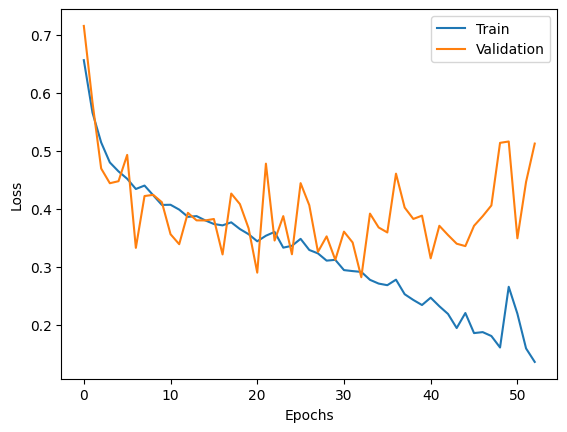

In [38]:
plotx = hist.history['loss']
plotty = hist.history['val_loss']
plt.plot(plotx)
plt.plot(plotty)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [39]:
# y_predtrain = MLP.predict(X_trainrs, verbose=0)
# y_predtrain = np.argmax(y_predtrain, axis=1)
# cm2 = confusion_matrix(np.argmax(y_train, axis=1), y_predtrain)
# disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=[0,1])
# disp2.plot()
# plt.show()
# print("F1 ->", f1_score(np.argmax(y_train, axis=1), y_predtrain))

In [40]:
from sklearn.metrics import f1_score
y_pred = MLP.predict(X_testrs, verbose=0)
y_pred = np.argmax(y_pred, axis=1)
MLP.evaluate(X_testrs, y_test, verbose=1)
y_comp = np.argmax(y_test, axis=1)
print("F1 ->", f1_score(y_comp, y_pred))
print("Balanced ACC ->", balanced_accuracy_score(y_comp, y_pred))
cm = confusion_matrix(y_comp, y_pred)
print(cm)

40/40 [==============================] - 0s 5ms/step - loss: 0.2852 - accuracy: 0.8633
F1 -> 0.5183098591549297
Balanced ACC -> 0.7178041357458518
[[988  84]
 [ 87  92]]


In [41]:
counter = 0
for i in range(len(y_comp)):
    if(y_pred[i] != y_comp[i]):
        counter+=1
counter

171

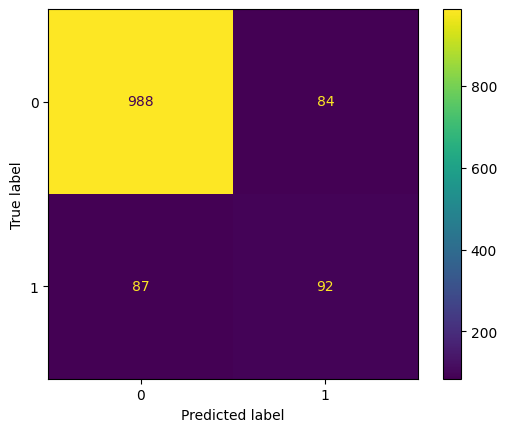

In [42]:
cm = confusion_matrix(y_comp, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()


# Valores finais a prever

In [43]:
# X_testfinal = np.load("Dados/Xtest_Classification1.npy")
# X_testfinal = X_testfinal.astype('float32')/255.0
# X_testfinal = X_testfinal.reshape(-1, 28,28,3)  
# y_final = MLP.predict(X_testfinal, verbose=0)
# y_final = np.argmax(y_final, axis=1)
# np.save("Dados/yfinal_Classification1.npy", y_final)


In [44]:
# counter1 = 0
# counter0 = 0
# for i in y_final:
#     if i == 1: 
#         counter1 += 1
#     if i == 0:
#         counter0 +=1
# print(counter0)
# print(counter1)